# Problem Introduction
From the [data repo](https://github.com/sflydatascience/homework1), our objective is given as: *"Develop a predictive model based on the provided Order and Online customer behavior data (data.zip). The assignment should produce a multi-class classification supervised learning model to predict product category (prodcat1) a customer is likely to order."*

**Modeling process will proceed as follows:**
1. Exploratory data analysis (EDA) of two data tables provided: order.csv and online.csv
2. Customer Segmentation, both for general interest and to further develop intuition about data
3. Summarize data, state any additional assumptions, formulate explicit classification definitions
4. Feature selection / engineering
5. Train / test several different classification algorithms
6. Examine and summarize modeling results
7. Discuss next steps

As an initial assumption, I'm going to assume that the data is extracted from real-world Shutterfly customer data, or at least artificially constructed to be similar to real-life Shutterfly data.

In [91]:
# import statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
# classification packages
from sklearn import ensemble
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [3]:
%matplotlib inline

# Step 1: EDA
## order.csv

In [4]:
# read in the order.csv file to pandas DataFrame
order_df = pd.read_csv('/Users/adouglas/Google Drive/projects/shutterfly_classification_model/data/order.csv')

In [5]:
# get shape and examine data at high-level
print(order_df.shape)
order_df.head(5)

(263278, 6)


,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


In [6]:
# from above can see nan values, is prodcat2 the only column with nan?
order_df.isna().sum()

custno          0
ordno           0
orderdate       0
prodcat2     1823
prodcat1        0
revenue         0
dtype: int64

In [7]:
# column descriptive statistics
order_df.describe()

,custno,ordno,prodcat2,prodcat1,revenue
count,263278.000000,263278.000000,261455.000000,263278.000000,263278.000000
mean,19244.733855,64173.395620,37.384330,2.920924,74.939302
std,19414.103037,43064.595961,44.639098,1.696565,43.277175
min,1.000000,1.000000,2.000000,1.000000,0.000000
25%,3438.000000,26505.000000,5.000000,2.000000,37.430000
50%,11389.500000,59040.500000,16.000000,2.000000,74.930000
75%,31459.000000,98340.750000,58.000000,4.000000,112.280000
max,71427.000000,154405.000000,263.000000,7.000000,150.000000


In [8]:
# from above, see minimum value of revenue is zero, which seems strange to have an order that costs nothing
# do these rows represent a significant portion of dataset?
len(order_df[order_df['revenue'] == 0])

4

In [9]:
# unique values, is there a single row for each order, or something else?
order_df.nunique()

custno        70264
ordno        149717
orderdate    149482
prodcat2        251
prodcat1          6
revenue       15001
dtype: int64

In [10]:
# looks like ordno is not unique, so perhaps each row is a specific product?
# what does a non-unique order look like?
order_df[order_df['ordno'] == 26505]

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
4735,17554,26505,2017-08-24 17:26:02,2.0,2,109.05
30257,17554,26505,2017-08-24 17:26:02,3.0,2,106.50
57092,17554,26505,2017-08-24 17:26:02,4.0,2,17.53
83361,17554,26505,2017-08-24 17:26:02,7.0,2,126.75
182892,17554,26505,2017-08-24 17:26:02,42.0,2,112.31


In [11]:
# what is the date range of our data?
# first convert to datetime object, then print min/max
order_df['orderdate'] = pd.to_datetime(order_df['orderdate'])
print(order_df['orderdate'].min())
print(order_df['orderdate'].max())

2016-01-01 05:05:14
2019-01-02 23:54:58


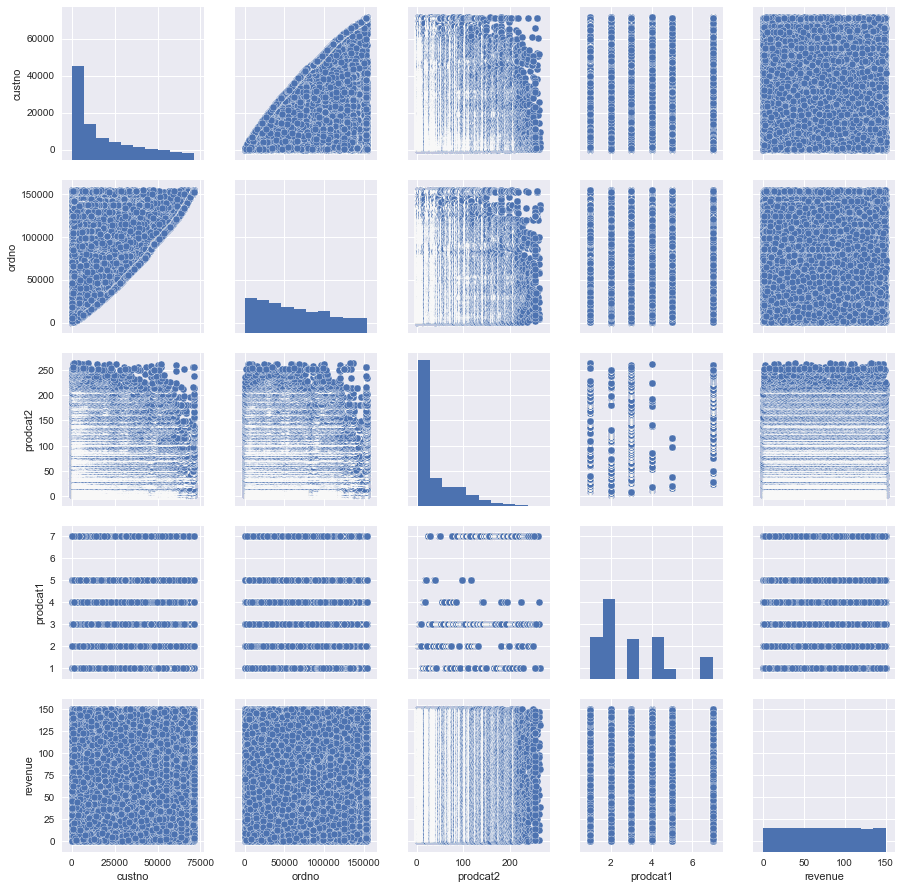

In [12]:
# feature pairplot, dropping nan rows (1,823 rows, less than 1% of overall dataset)
sns.pairplot(order_df.dropna());

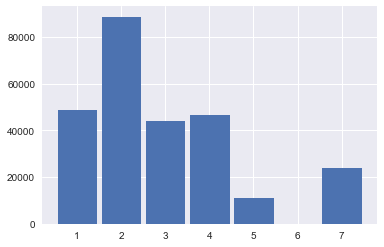

In [13]:
# pairplot doesn't show the prodcat1 histogram well, so lets get a better look at that
plt.hist(order_df['prodcat1'], bins=[0.01,1.01,2.01,3.01,4.01,5.01,6.01,7.01], rwidth=0.9, align='right');

In [14]:
# what is relative percentage of our target variable?
order_df['prodcat1'].value_counts(normalize=True)

2    0.336845
1    0.184869
4    0.177307
3    0.167196
7    0.091318
5    0.042465
Name: prodcat1, dtype: float64

### Initial High-Level Summary of order.csv
- about a quarter-million rows, 6 columns
- each row represents the order of a single product, and each row can be part of a larger, multiple-product order
- data spans three years, encompassing years 2016-2018 inclusive
- no serious missing data issues, *prodcat2* has < 1% missing. Will decide what do about missing data when value of *prodcat2* is determined
- classes are imbalanced, but not to the extreme. Largest class (category 2) is roughly 8x smallest class (category 5).
- values of columns in general align with expectations, except:
  - *revenue*: minimum value of revenue column is zero, which is a bit surprising. But only 4 rows of entire dataset -- perhaps was a sale or discounted item
  - *revenue*: from revenue histogram in pairplot above, can see it's uniformly distributed, which is somewhat surprising, as you'd maybe expect some sort of non-uniform distribution when it comes to price. Perhaps the data was sampled with the goal of a uniform revenue distribution
  - *prodcat1*: categorical variable (our target) with six unique values, however the actual values omit *6*. Not a big deal, but important to keep in mind if doing some sort of iteration
- additional observations from pairplot:
  - nothing really appears to stand out as unusual -- i.e. nothing immediately obvious that would help with prediction modeling. Perhaps a deeper dive into variable relationships will reveal more.

### Additional EDA - Relationships between specific variables

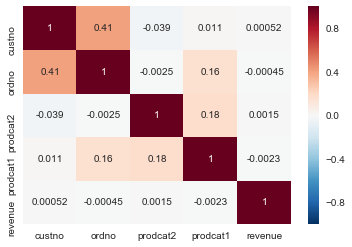

In [15]:
sns.heatmap(order_df.corr(), annot=True);

Data is almost suspiciously uncorrelated. Slight positive correlation between *prodcat1* and *ordno* and *prodcat2*. Positive correlation between *ordno* and *custno* makes sense since order number increasing sequentially as new orders are placed, as does customer number as new customers sign up.

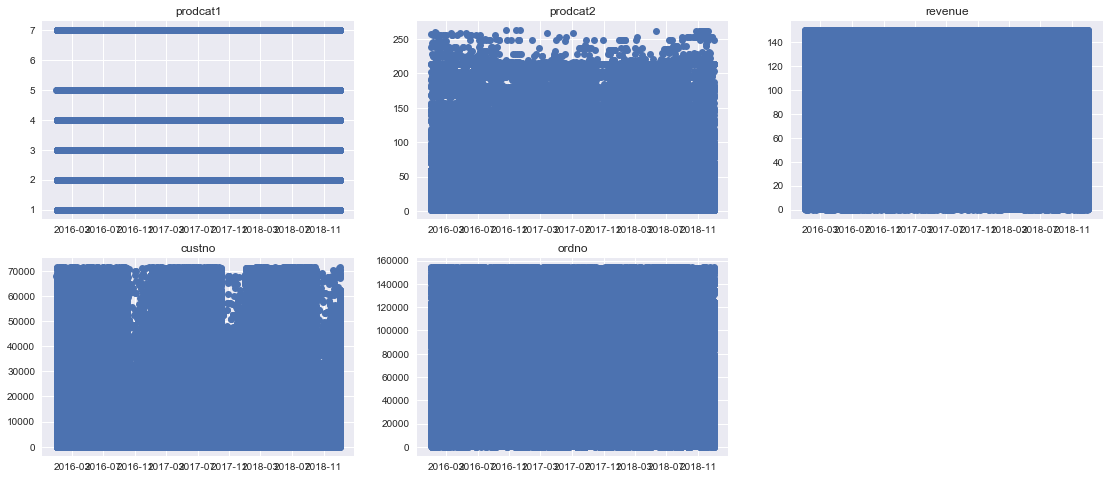

In [16]:
# what about the relationship between variables and time?
plt.figure(figsize=(19,8))
plt.subplot(2, 3, 1)
plt.title('prodcat1')
plt.plot_date(order_df['orderdate'], order_df['prodcat1'])
plt.subplot(2, 3, 2)
plt.title('prodcat2')
plt.plot_date(order_df['orderdate'], order_df['prodcat2'])
plt.subplot(2, 3, 3)
plt.title('revenue')
plt.plot_date(order_df['orderdate'], order_df['revenue'])
plt.subplot(2, 3, 4)
plt.title('custno')
plt.plot_date(order_df['orderdate'], order_df['custno'])
plt.subplot(2, 3, 5)
plt.title('ordno')
plt.plot_date(order_df['orderdate'], order_df['ordno']);

One would expect order number and customer number to increase over time, as new orders and customers are added to the database. The fact that the data does not exhibit this pattern leads me to believe that custno / ordno were randomized.

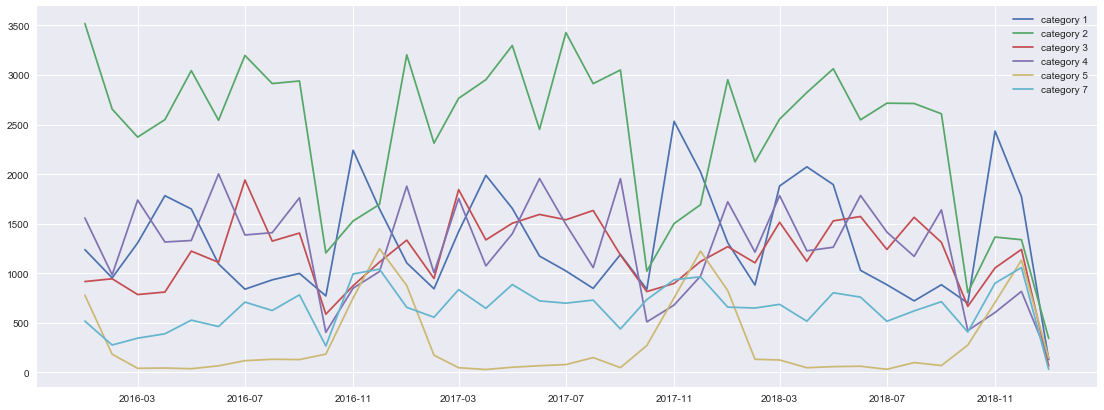

In [17]:
# perhaps there is a relationship between our target variable and time. Are some categories more popular at certain times of the year?
plt.figure(figsize=(19,7))
plt.plot_date(order_df[order_df['prodcat1'] == 1].set_index(order_df[order_df['prodcat1'] == 1]['orderdate']).groupby(pd.Grouper(freq='MS')).count().index, 
              order_df[order_df['prodcat1'] == 1].set_index(order_df[order_df['prodcat1'] == 1]['orderdate']).groupby(pd.Grouper(freq='MS')).count()['revenue'], fmt='-', label='category 1');

plt.plot_date(order_df[order_df['prodcat1'] == 2].set_index(order_df[order_df['prodcat1'] == 2]['orderdate']).groupby(pd.Grouper(freq='MS')).count().index, 
              order_df[order_df['prodcat1'] == 2].set_index(order_df[order_df['prodcat1'] == 2]['orderdate']).groupby(pd.Grouper(freq='MS')).count()['revenue'], fmt='-', label='category 2');

plt.plot_date(order_df[order_df['prodcat1'] == 3].set_index(order_df[order_df['prodcat1'] == 3]['orderdate']).groupby(pd.Grouper(freq='MS')).count().index, 
              order_df[order_df['prodcat1'] == 3].set_index(order_df[order_df['prodcat1'] == 3]['orderdate']).groupby(pd.Grouper(freq='MS')).count()['revenue'], fmt='-', label='category 3');

plt.plot_date(order_df[order_df['prodcat1'] == 4].set_index(order_df[order_df['prodcat1'] == 4]['orderdate']).groupby(pd.Grouper(freq='MS')).count().index, 
              order_df[order_df['prodcat1'] == 4].set_index(order_df[order_df['prodcat1'] == 4]['orderdate']).groupby(pd.Grouper(freq='MS')).count()['revenue'], fmt='-', label='category 4');

plt.plot_date(order_df[order_df['prodcat1'] == 5].set_index(order_df[order_df['prodcat1'] == 5]['orderdate']).groupby(pd.Grouper(freq='MS')).count().index, 
              order_df[order_df['prodcat1'] == 5].set_index(order_df[order_df['prodcat1'] == 5]['orderdate']).groupby(pd.Grouper(freq='MS')).count()['revenue'], fmt='-', label='category 5');

plt.plot_date(order_df[order_df['prodcat1'] == 7].set_index(order_df[order_df['prodcat1'] == 7]['orderdate']).groupby(pd.Grouper(freq='MS')).count().index, 
              order_df[order_df['prodcat1'] == 7].set_index(order_df[order_df['prodcat1'] == 7]['orderdate']).groupby(pd.Grouper(freq='MS')).count()['revenue'], fmt='-', label='category 7');

plt.legend();

There is a very clear relationship between some of the categories of *prodcat1* and time. Orders of Category 2, our most popular, drop off dramatically in Oct-Dec, while we see significant increases in other categories during that same timeframe. Category 5 in particular sees almost all orders from Nov-Jan (perhaps holiday cards?). Will definitely want to incorporate a monthly indicator variable in the final prediction model.

# EDA Continued
## online.csv

In [18]:
# read in the online.csv file to pandas DataFrame
online_df = pd.read_csv('/Users/adouglas/Google Drive/projects/shutterfly_classification_model/data/online.csv')

In [19]:
# get shape and examine data at high-level
print(online_df.shape)
online_df.head(5)

(954774, 7)


,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [20]:
# from above can see nan values, is event1 the only column with nan?
online_df.isna().sum()

session          0
visitor          0
dt               0
custno           0
category         0
event1      789846
event2           0
dtype: int64

In [21]:
# column descriptive statistics
online_df.describe()

,session,visitor,custno,category,event1,event2
count,9.547740e+05,954774.000000,954774.000000,954774.000000,164928.000000,954774.000000
mean,1.893075e+06,246963.121538,37011.541473,2.684933,4.501576,5.666678
std,1.086779e+06,145929.540403,21559.691539,0.571617,3.494639,2.368242
min,2.000000e+00,1.000000,6.000000,1.000000,1.000000,1.000000
25%,9.554362e+05,125528.250000,17985.000000,2.000000,1.000000,4.000000
50%,1.903075e+06,252901.000000,38040.000000,3.000000,4.000000,7.000000
75%,2.845886e+06,377563.000000,56516.000000,3.000000,7.000000,7.000000
max,3.750761e+06,505850.000000,71427.000000,3.000000,11.000000,10.000000


In [22]:
# unique values
online_df.nunique()

session     850235
visitor     259950
dt          942579
custno       57584
category         3
event1          10
event2          10
dtype: int64

In [23]:
# what percentage of the whole dataset is comprised of single-event sessions?
len(online_df['session'].unique()) / len(online_df)

0.8905091676145349

In [24]:
# what does a single session look like?
online_df[online_df['session'] == 3626321].sort_values('dt')

,session,visitor,dt,custno,category,event1,event2
832597,3626321,337292,2016-07-31 05:03:15,29788,3,1.0,7
259167,3626321,337292,2016-07-31 05:48:37,29788,3,NaN,3
761425,3626321,337292,2016-07-31 06:19:38,29788,3,NaN,9


In [25]:
# what does a single session look like?
online_df[online_df['session'] == 1804477].sort_values(['dt', 'event1'])

,session,visitor,dt,custno,category,event1,event2
814134,1804477,356520,2017-04-09 09:46:06,67,2,1.0,7
126763,1804477,356520,2017-04-09 09:46:06,67,2,NaN,7
68442,1804477,356520,2017-04-09 09:49:47,67,2,NaN,3
83889,1804477,356520,2017-04-09 09:50:24,67,2,NaN,4
174251,1804477,356520,2017-04-09 09:51:34,67,2,NaN,9


In [26]:
# what is the date range of our data?
# first convert to datetime object, then print min/max
online_df['dt'] = pd.to_datetime(online_df['dt'])
print(online_df['dt'].min())
print(online_df['dt'].max())

2016-01-01 00:00:08
2017-12-31 23:58:05


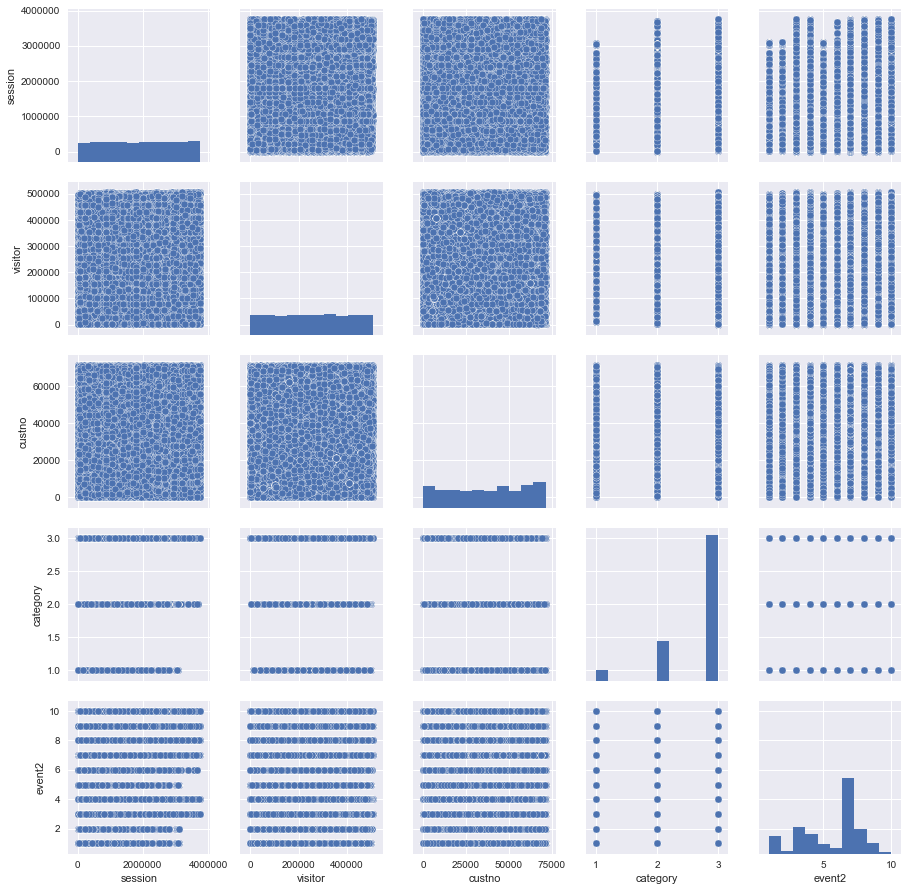

In [27]:
# feature pairplot, dropping event1 column due to NaNs
sns.pairplot(online_df.drop(columns=['event1']));

In [28]:
# what is relative percentage of our target variable?
online_df['category'].value_counts(normalize=True)

3    0.740406
2    0.204122
1    0.055473
Name: category, dtype: float64

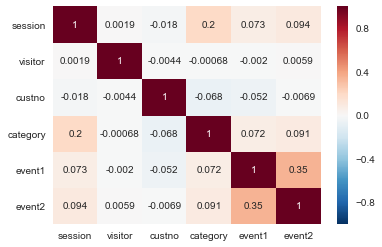

In [29]:
sns.heatmap(online_df.corr(), annot=True);

### High-Level Summary of online.csv
- almost a million rows, 7 columns
- each row represents an event (or maybe event pair) during an online session, and each row can be part of a larger multi-event session
- data spans two years, encompassing years 2016-2017 inclusive
- *event1* is missing almost all of its values. It could represent a unique online event, such as initial landing on the website. Given that a couple sessions start with non-NaN *event1s*, I'm thinking it's something like this
- couple issues here that make it hard to see coupling this data with the main dataset we're building a predictive model on:
  - the time periods don't align. online.csv only goes until 2017, while our main dataset goes all the way through 2018.
  - online.csv only includes data on three of our six target classes, meaning we're missing data on fully half of our target classes. 
  
Despite the issues above, there still may be some predictive power in including online.csv in our predictive model. Let's further examine two things:
1. What percentage of our customers from order.csv appear in online.csv? If it's a sizable percentage then perhaps we are capturing the online behavior of most of our customers
2. Is there a clear relationship between viewing a specific category in online.csv and ordering that product in order.csv? If so, could be some predictive power to be captured even if only half our target classes are included in online.csv

In [30]:
customers_in_online = list(set([num for num in online_df['custno'] if num in order_df['custno']]))
print('Number of customers appearing in both online and order datasets:', len(customers_in_online))
print('Percentage of customers in order dataset that are also in online:', len(customers_in_online) / len(order_df['custno'].unique()))

Number of customers appearing in both online and order datasets: 57584
Percentage of customers in order dataset that are also in online: 0.8195377433678698


In [31]:
order_df[order_df['custno'] == 6]

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
1941,6,6,2018-01-28 06:48:34,2.0,2,72.67
7881,6,6,2018-01-28 06:48:34,3.0,2,44.29
48259,6,6,2018-01-28 06:48:34,4.0,2,10.02
64002,6,6,2018-01-28 06:48:34,5.0,2,131.38
183936,6,6,2018-01-28 06:48:34,43.0,3,48.10


In [32]:
# for every product category viewed by a customer, what percentage corresponds with an actual order?
total_products_viewed = 0
products_viewed_and_purchased = 0

for customer in customers_in_online:
    for category in online_df[online_df['custno'] == customer]['category'].unique():
        if category in order_df[order_df['custno'] == customer]['prodcat1'].unique():
            products_viewed_and_purchased += 1
        total_products_viewed += 1

In [33]:
print(products_viewed_and_purchased, '/', total_products_viewed)
print(products_viewed_and_purchased / total_products_viewed)

28335 / 91689
0.30903379903805256


Among 91,689 product categories viewed online by customers, ~31% also correspond with a purchase. (A good additional check would be to confirm the orders came after viewing the product.)

For now, however, given the time differences between the two datasets, the lack of target classes in the online.csv dataset, and the percentages above, I'm going to exclude online.csv from the predictive model. Given more time, it may be worth exploring if feature engineering can add predictive power from the online.csv dataset.

---

# Step 2: Customer Segmentation
Looking at the order.csv dataset, can we say anything interesting about customer segments?

In [34]:
# create a custom table for each unique customer, along with summary variables
customer_df = pd.DataFrame(order_df['custno'].unique(), columns=['custno'])

In [35]:
# how many total products did each customer order?
customer_df['prod_count']  = customer_df.apply(lambda row: len(order_df[order_df['custno'] == row['custno']]), axis=1)
# how many total orders did each customer make?
customer_df['order_count'] = customer_df.apply(lambda row: len(order_df[order_df['custno'] == row['custno']]['ordno'].unique()), axis=1)

In [36]:
# how many of each product category did each customer order?
customer_df['cat_1'] = customer_df.apply(lambda row: len(order_df[(order_df['custno'] == row['custno']) & (order_df['prodcat1'] == 1)]), axis=1)
customer_df['cat_2'] = customer_df.apply(lambda row: len(order_df[(order_df['custno'] == row['custno']) & (order_df['prodcat1'] == 2)]), axis=1)
customer_df['cat_3'] = customer_df.apply(lambda row: len(order_df[(order_df['custno'] == row['custno']) & (order_df['prodcat1'] == 3)]), axis=1)
customer_df['cat_4'] = customer_df.apply(lambda row: len(order_df[(order_df['custno'] == row['custno']) & (order_df['prodcat1'] == 4)]), axis=1)
customer_df['cat_5'] = customer_df.apply(lambda row: len(order_df[(order_df['custno'] == row['custno']) & (order_df['prodcat1'] == 5)]), axis=1)
customer_df['cat_7'] = customer_df.apply(lambda row: len(order_df[(order_df['custno'] == row['custno']) & (order_df['prodcat1'] == 7)]), axis=1)

In [37]:
# check out the data
customer_df.sample(3)

,custno,prod_count,order_count,cat_1,cat_2,cat_3,cat_4,cat_5,cat_7
29349,62341,1,1,0,1,0,0,0,0
48665,14374,1,1,0,0,0,1,0,0
10097,59443,2,1,0,1,1,0,0,0


In [38]:
# what percentage of our customer base has only ever made one order?
len(customer_df[customer_df['order_count'] == 1]) / len(customer_df)

0.9118040532847547

In [39]:
# what percentage of total orders were made by the top 1% of customers?
customer_df['order_count'].sort_values(ascending=False)[:int(len(customer_df)*0.01)].sum() / customer_df['order_count'].sum()

0.27893292010927284

In [40]:
# what percentage of customers who ordered more than one product ordered from only one category?
len(
customer_df[((customer_df['prod_count'] == customer_df['cat_1']) | 
             (customer_df['prod_count'] == customer_df['cat_2']) | 
             (customer_df['prod_count'] == customer_df['cat_3']) | 
             (customer_df['prod_count'] == customer_df['cat_4']) | 
             (customer_df['prod_count'] == customer_df['cat_5']) | 
             (customer_df['prod_count'] == customer_df['cat_7'])) &
             (customer_df['prod_count'] > 1)]
) / len(customer_df)

0.3504212683593305

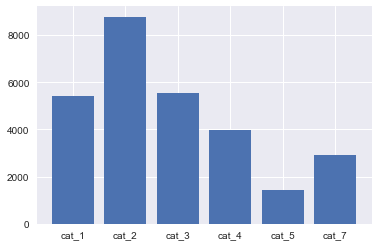

In [41]:
# plt.title('Category Purchased Among First-Time Buyers')
plt.bar(left=range(6), 
        height=customer_df[customer_df['prod_count'] == 1].groupby('prod_count')\
        .sum()[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_7']].iloc[0],
        tick_label=['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_7']);

In [42]:
# what is relative percentage of our target variable for first-time buyers?
customer_df[customer_df['prod_count'] == 1].groupby('prod_count')\
        .sum()[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_7']].iloc[0].sort_values(ascending=False)\
/ len(customer_df[customer_df['prod_count'] == 1])

cat_2    0.312803
cat_3    0.197605
cat_1    0.192508
cat_4    0.142394
cat_7    0.103579
cat_5    0.051112
Name: 1, dtype: float64

In [43]:
# how does that compare to overall data?
order_df['prodcat1'].value_counts(normalize=True)

2    0.336845
1    0.184869
4    0.177307
3    0.167196
7    0.091318
5    0.042465
Name: prodcat1, dtype: float64

As a last bit of customer segmentation before summarizing the results, let's look at frequency of purchase.

In [44]:
# select only customers that had more than one order, and group by those orders
# really interested here in time, but bring along num products ordered and total revenue just in case
# sort by orderdate per customer
freq_df = order_df[order_df['custno'].isin(customer_df[customer_df['order_count'] > 1]['custno'].values)]\
                  .groupby(['custno', 'ordno'], as_index=False).agg({'orderdate':'min','prodcat1':'count','revenue':'sum'})\
                  .sort_values(['custno','orderdate'])

freq_df.head(6)

,custno,ordno,orderdate,prodcat1,revenue
2,2,70848,2016-01-26 14:14:21,1,23.84
4,2,112461,2016-01-26 14:23:21,1,94.50
0,2,2,2016-03-29 13:04:27,1,13.58
1,2,15645,2016-08-29 10:50:33,1,149.92
3,2,78052,2017-05-02 12:24:02,2,144.27
5,3,3,2017-01-31 19:16:49,1,95.76


In [45]:
# let's get the days between each order, can plot a histogram and look at any other interesting statistics
days_between_orders = []

custnos = list(freq_df['custno'].unique())

for cust_num in custnos:
    num_orders = len(freq_df[freq_df['custno'] == cust_num])
    
    for i in range(num_orders-1):
        days_between = (freq_df[freq_df['custno'] == cust_num].iloc[i+1]['orderdate'] - \
                        freq_df[freq_df['custno'] == cust_num].iloc[i]['orderdate']).days
        days_between_orders.append(days_between)

In [46]:
# percentage of same-day orders?
print('Same-day orders:', len([day for day in days_between_orders if day == 0]) / len(days_between_orders))
# percentage of same-week orders?
print('Same-week orders:', len([day for day in days_between_orders if day <= 6]) / len(days_between_orders))

Same-day orders: 0.12871760663536932
Same-week orders: 0.35826211722653645


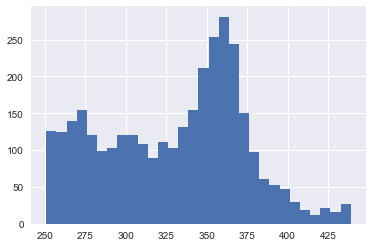

In [47]:
# what about orders exactly one year after? Do we see a higher frequency on this anneversery?
plt.hist([days for days in days_between_orders if days > 250 and days < 440], bins=30);

## Customer Segmentation Summary
- 91% of customers place only one order, at least within the timeframe of our data
- The top 1% of customers, by orders placed, are responsible for 28% of total orders
- Among the customers who ordered more than one product, 35% ordered from only a single product category
- The distribution of product category purchased for first-time buyers is pretty similar to the overall category purchase rate
  - Category 3 did go from the fourth-most purchased category to the second-most, among first-time buyers
- Among customers who placed more than one order:
  - 13% of follow-on orders were placed on the same day as a previous order
  - 36% of follow-on orders were placed during the same week as a previous order
- There is a clear spike in orders around the one-year anniversary of a previous order

---

# Step 3: Summarize, Formalize Prediction Problem

## Data Summary
The rows of the order.csv file represent products ordered by customers over a three-year period. Some customers appear multiple times, although the vast majority of customers (91%) placed only a single order. Among the six classes, class 3 was ordered the most often (34%) and class 5 the least (4%). For some classes, there is a clear relationship in order frequency and time, for example class 5 is almost always only ordered between the months of Nov-Jan.

online.csv represents online events carried out by our customers, however there is significant lack of overlap between this file and order.csv which makes it hard to combine. online.csv includes only two years of data, and includes just half of our target variables. 

## Prediction Problem
For this prediction problem, I assume that in a real-world scenario, a customer or list of customers would be presented and the goal would be to predict the product category they're most likely to order. Thus, our features and model should be summarized around individual customers and include any history or other defining characteristics we have for them.

We will thus proceed as follows:
- create aggregated table that summarize historical customer behavior
- Randomly split aggregated table for training and testing purposes
  - Given above formulation, split will need to consider table as time series data. i.e. we don't want to have a customer's future order in the training data and test on a past order. So we'll only select most recent orders to be in the testing set.
- Train several multi-class classification models and examine results

# Step 4: Feature Engineering / Selection
Our aggregated table will consider each product purchase as an individual event, given our problem of predicting a single product category (rather than a multi-label formulation that returns a probability for each category). For each purchase event, we will then summarize any historical information we have about the customers, and train a model on the product category target.

In [48]:
# bring over the order_df as our base table
# will not likely use custno or ordno in prediction, but bringing along just in case
event_df = order_df[['prodcat1', 'custno', 'ordno', 'orderdate']].copy(deep=True)

In [49]:
# to include some element of time, we'll add an indicator variable noting if the order is within the Oct-Jan
# window, since this is when we see the most deviation from normal ordering behavior by category
# a good next step would be to explore different iterations of accounting for time, such as one-hot encoding the month of the order
event_df['is_holiday_season'] = event_df.apply(lambda row: 1 if (row['orderdate'].month >= 10 or row['orderdate'].month == 1) else 0, 
                                               axis=1)

In [50]:
# helper function to get number of previous orders placed by customer when current product is ordered
def get_prev_order_cnt(row):
    temp_df = order_df[(order_df['custno'] == row['custno']) & 
                       (order_df['ordno']  != row['ordno']) & 
                       (order_df['orderdate'] < row['orderdate'])]
    return len(set(temp_df['ordno']))

In [51]:
# calculate previous order count
event_df['prev_order_cnt'] = event_df.apply(get_prev_order_cnt, axis=1)
event_df.sample(3)

,prodcat1,custno,ordno,orderdate,is_holiday_season,prev_order_cnt
14440,2,45869,85352,2017-07-09 23:09:36,0,0
2595,2,2597,20503,2018-04-23 07:51:09,0,26
155895,7,9971,84460,2017-06-15 11:36:51,0,76


In [52]:
# helper function to get number of times each product category was previously ordered by customer
def get_prev_prod_cat_cnt(row, prodcat):
    temp_df = order_df[(order_df['custno'] == row['custno']) & 
                       (order_df['ordno']  != row['ordno']) & 
                       (order_df['orderdate'] < row['orderdate']) & 
                       (order_df['prodcat1'] == prodcat)]
    return len(temp_df)

In [53]:
# calculate previous product category order count
event_df['cat_1_cnt'] = event_df.apply(get_prev_prod_cat_cnt, prodcat=1, axis=1)
event_df['cat_2_cnt'] = event_df.apply(get_prev_prod_cat_cnt, prodcat=2, axis=1)
event_df['cat_3_cnt'] = event_df.apply(get_prev_prod_cat_cnt, prodcat=3, axis=1)
event_df['cat_4_cnt'] = event_df.apply(get_prev_prod_cat_cnt, prodcat=4, axis=1)
event_df['cat_5_cnt'] = event_df.apply(get_prev_prod_cat_cnt, prodcat=5, axis=1)
event_df['cat_7_cnt'] = event_df.apply(get_prev_prod_cat_cnt, prodcat=7, axis=1)

In [54]:
# check out the data
event_df.sample(5)

,prodcat1,custno,ordno,orderdate,is_holiday_season,prev_order_cnt,cat_1_cnt,cat_2_cnt,cat_3_cnt,cat_4_cnt,cat_5_cnt,cat_7_cnt
170876,5,7961,143313,2017-12-11 07:15:41,1,17,1,7,6,12,0,3
159092,3,39363,69327,2017-04-09 05:35:53,0,0,0,0,0,0,0,0
73089,2,36538,63646,2016-06-11 18:14:24,0,0,0,0,0,0,0,0
191778,7,46626,87567,2018-09-16 06:13:28,0,0,0,0,0,0,0,0
159469,3,480,558,2018-03-28 20:32:45,0,0,0,0,0,0,0,0


In [56]:
# pickle the dataFrame because that took forever, good idea to see if can improve calculation time on those features
pickle.dump(event_df, open('/Users/adouglas/Google Drive/projects/shutterfly_classification_model/event_df.p','wb'))

In [ ]:
# load df as needed
# event_df = pickle.load(open('/Users/adouglas/Google Drive/projects/shutterfly_classification_model/event_df.p', 'rb'))

In [57]:
# also, the absolute number of category orders is probably not as important as the relative frequency
# of category order, so we'll normalize the category count by event
def normalize_cat_cnt(row, cat_column):
    tot_products_ordered = row[['cat_1_cnt', 'cat_2_cnt', 'cat_3_cnt', 'cat_4_cnt', 'cat_5_cnt', 'cat_7_cnt']].sum()
    cat_cnt = row[cat_column]
    
    if tot_products_ordered == 0:
        return round(0.0, 4)
    else:
        return round(cat_cnt / tot_products_ordered, 4)

In [58]:
# calculate our category percentages
event_df['cat_1_perc'] = event_df.apply(normalize_cat_cnt, cat_column='cat_1_cnt', axis=1)
event_df['cat_2_perc'] = event_df.apply(normalize_cat_cnt, cat_column='cat_2_cnt', axis=1)
event_df['cat_3_perc'] = event_df.apply(normalize_cat_cnt, cat_column='cat_3_cnt', axis=1)
event_df['cat_4_perc'] = event_df.apply(normalize_cat_cnt, cat_column='cat_4_cnt', axis=1)
event_df['cat_5_perc'] = event_df.apply(normalize_cat_cnt, cat_column='cat_5_cnt', axis=1)
event_df['cat_7_perc'] = event_df.apply(normalize_cat_cnt, cat_column='cat_7_cnt', axis=1)

In [61]:
# check out the data
event_df.sample(5)

,prodcat1,custno,ordno,orderdate,is_holiday_season,prev_order_cnt,cat_1_cnt,cat_2_cnt,cat_3_cnt,cat_4_cnt,cat_5_cnt,cat_7_cnt,cat_1_perc,cat_2_perc,cat_3_perc,cat_4_perc,cat_5_perc,cat_7_perc
258987,7,18676,28414,2016-04-20 11:31:50,0,0,0,0,0,0,0,0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
97085,3,9470,50390,2018-04-15 16:02:00,0,5,0,3,0,1,3,0,0.0,0.4286,0.0000,0.1429,0.4286,0.0000
142347,4,2761,69125,2018-06-21 17:29:41,0,20,14,1,5,5,2,1,0.5,0.0357,0.1786,0.1786,0.0714,0.0357
171450,5,9263,90191,2018-11-25 10:12:20,1,13,0,7,0,6,3,0,0.0,0.4375,0.0000,0.3750,0.1875,0.0000
82421,2,6444,8249,2018-03-24 18:31:54,0,0,0,0,0,0,0,0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000


In [62]:
# pickle the dataFrame because that took forever, good idea to see if can improve calculation time on those features
pickle.dump(event_df, open('/Users/adouglas/Google Drive/projects/shutterfly_classification_model/event_df.p','wb'))

In [ ]:
# load df as needed
# event_df = pickle.load(open('/Users/adouglas/Google Drive/projects/shutterfly_classification_model/event_df.p', 'rb'))

In [63]:
# the last column we'll add is one denoting if the order is most recent
# this is mainly so we can easily split into train / test, but perhaps there is some value in knowing
# the most recent order for those customers who ordered more than once
def is_most_recent_order(row):
    return 1 if row['orderdate'] == event_df[event_df['custno'] == row['custno']]['orderdate'].max() else 0

In [64]:
# calculate our column
event_df['is_most_recent'] = event_df.apply(is_most_recent_order, axis=1)

In [65]:
# check out the data
event_df.sample(5)

,prodcat1,custno,ordno,orderdate,is_holiday_season,prev_order_cnt,cat_1_cnt,cat_2_cnt,cat_3_cnt,cat_4_cnt,cat_5_cnt,cat_7_cnt,cat_1_perc,cat_2_perc,cat_3_perc,cat_4_perc,cat_5_perc,cat_7_perc,is_most_recent
233260,7,5376,62784,2016-12-05 19:13:02,1,9,2,0,7,0,0,3,0.1667,0.0000,0.5833,0.0000,0.0000,0.2500,0
92035,3,4247,126729,2016-06-18 07:31:12,0,5,0,2,2,0,0,1,0.0000,0.4000,0.4000,0.0000,0.0000,0.2000,0
238949,1,2049,36457,2017-11-05 11:30:35,1,4,0,6,0,6,1,1,0.0000,0.4286,0.0000,0.4286,0.0714,0.0714,0
84944,3,44551,80994,2016-09-11 12:10:04,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
200327,4,34444,59510,2018-02-12 19:30:21,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1


# Step 5: Train / Test Classification Algorithms
Our holdout set will be a random selection of the most recent orders in our event_df

In [67]:
# how many events are the most recent for their customer?
len(event_df[event_df['is_most_recent'] == 1]) / len(event_df)

0.5193749572695022

Let's take half of these events, which will equate to a roughly 75 / 25 train / test split

In [69]:
# get our index values to shuffle
split_index = list(event_df[event_df['is_most_recent'] == 1].index)
# shuffle the index
random.shuffle(split_index)

In [70]:
# select the first half, this will be our testing set
test_index = split_index[:int(len(split_index)/2)]
len(test_index)

68370

In [71]:
# split our dataset into train / test groups
train_df = event_df.drop(index=test_index)
test_df = event_df.iloc[test_index]

In [73]:
# sizes of our train / test groups
print(len(train_df), 'training rows.', len(test_df), 'testing rows.')
print('Percent of testing data:', len(test_df) / len(event_df))

194908 training rows. 68370 testing rows.
Percent of testing data: 0.2596874786347511


### Algorithm 1: Gradient Boosted Decision Trees

In [80]:
# define our model, slight modifications to hyperparameters
gb = ensemble.GradientBoostingClassifier(n_estimators=200, subsample=0.9, max_depth=4)

In [82]:
gb.fit(X=train_df[['prev_order_cnt', 'is_holiday_season', 'cat_1_perc', 'cat_2_perc', 
                   'cat_3_perc', 'cat_4_perc', 'cat_5_perc', 'cat_7_perc', 'is_most_recent']],
       y=train_df['prodcat1'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)

In [89]:
# micro-averaging accuracy
gb_score = gb.score(X=test_df[['prev_order_cnt', 'is_holiday_season', 'cat_1_perc', 'cat_2_perc', 
                   'cat_3_perc', 'cat_4_perc', 'cat_5_perc', 'cat_7_perc', 'is_most_recent']],
                    y=test_df['prodcat1'])
gb_score

0.38688021061869243

A naive baseline accuracy could be to predict the most common class, which should be class 2. What is this baseline?

In [88]:
baseline_accuracy = len(event_df[event_df['prodcat1'] == 2]) / len(event_df)
baseline_accuracy

0.33684546373035346

In [90]:
# some improvement over baseline
gb_score / baseline_accuracy - 1

0.14853917382242687

### Algorithm 2: One vs. Rest with SVM

In [92]:
# define our classifier with default hyperparameters
ovr_svm = OneVsRestClassifier(svm.LinearSVC())

In [93]:
ovr_svm.fit(X=train_df[['prev_order_cnt', 'is_holiday_season', 'cat_1_perc', 'cat_2_perc', 
                   'cat_3_perc', 'cat_4_perc', 'cat_5_perc', 'cat_7_perc', 'is_most_recent']],
            y=train_df['prodcat1'])

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1)

In [94]:
# micro-averaging accuracy
ovr_svm_score = ovr_svm.score(X=test_df[['prev_order_cnt', 'is_holiday_season', 'cat_1_perc', 'cat_2_perc', 
                                         'cat_3_perc', 'cat_4_perc', 'cat_5_perc', 'cat_7_perc', 'is_most_recent']],
                              y=test_df['prodcat1'])
ovr_svm_score

0.3840573350884891

In [98]:
# some improvement over baseline
ovr_svm_score / baseline_accuracy - 1

0.14015884564777448

# Step 6: Summarize Classification Results
Through all that feature engineering we were able to improve baseline accuracy by about 14-15%, which while not great, is still a pretty good result considering the relatively limited features available for prediction. We were able to get close to 40% accuracy knowing only time of year the order was placed and the order history of our customers (and 51% of our order events had no prior history attached to them).

While there was probably more to do with the online.csv dataset, it's limited time period and lack of target classes limited its usefulness. Getting a fully realized version of this dataset, perhaps along with some demographic characteristics of our customers, could potentially significantly improve prediction accuracy. And, as an analyst's work is never done, there are plenty more things we could do given more time. See the below section for a list of some of the possible next steps.

# Step 7: Next Steps
Given more time, possible next steps include:
- Spend more time with feature engineering. The timing element was only captured with the is_holiday_season feature, could be more to do there such as one-hot-encoding month (or weekday?)
- Upsample / downsample imbalanced classes during training
- Spend more time on hyperparameter tuning of classification algorithms
- Explore effectiveness of different algorithms: neural networks, logistic regression, KNN
- Combine multiple trained models into ensemble, predict based on ensemble voting
- Consider other classification evaluation metrics: log-loss, precision / recall